In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original', data_home='./')
X_, y_ = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = X_[:60000], X_[60000:], y_[:60000], y_[60000:]
shuffle_index = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

## fetch 5 in MNIST datasets

In [3]:
y5_index = np.where(y_ == 5)
X5 = X_[y5_index]
X5.shape

(6313, 784)

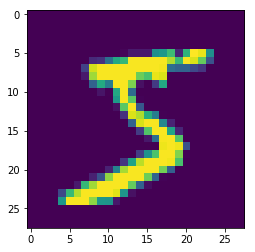

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
X5 = X5 / 255
X5_train, X5_test = X5[:5000], X5[5000:]
plt.imshow(X5[0].reshape(28, 28))

# GAN

In [32]:
tf.reset_default_graph()

n_g_inputs = 28 * 28
n_g_hidden1 = 100
n_g_hidden2 = 100
n_g_outputs = n_g_inputs

n_d_inputs = 28*28
n_d_hidden1 = 75
n_d_hidden2 = 75
n_d_output = 2

def generate_base(n_g_inputs, batch_size, epoch, itr):
    base = tf.random_uniform(shape=(batch_size, n_g_inputs), minval=0, maxval=1, seed=epoch+itr)
    return base

def minibatch(X, batch_size):
    index = np.random.randint(0, len(X), batch_size)
    X_batch = X[index]
    return X_batch

def return_y(batch_size):
    y0 = np.zeros(batch_size)
    y1 = np.ones(batch_size)
    y = np.r_[y0, y1]
    return tf.constant(y, dtype=tf.int32)

g_X = tf.placeholder(tf.float32, shape=(None, n_g_inputs), name='g_X')
MNIST_X = tf.placeholder(tf.float32, shape=(None, n_g_inputs), name='MNIST_X')

d_X = tf.placeholder(tf.float32, shape=(None, n_d_inputs), name='d_X')
d_y = tf.placeholder(tf.float32, shape=(None), name='d_y')
n_batchies = tf.placeholder(tf.int32, shape=(None), name='n_batchies')

with tf.name_scope('generator'):
    g_hidden1 = tf.layers.dense(g_X, n_g_hidden1, activation=tf.nn.leaky_relu, name='g_hidden1')
    g_hidden2 = tf.layers.dense(g_hidden1, n_g_hidden2, activation=tf.nn.leaky_relu, name='g_hidden2')
    g_output = tf.layers.dense(g_hidden2, n_g_outputs, activation=tf.nn.leaky_relu, name='g_output')
    g_concat = tf.concat([g_output, MNIST_X], 0)
    
with tf.name_scope('discriminator'):
    d_hidden1 = tf.layers.dense(g_output, n_d_hidden1, activation=tf.nn.relu, name='d_hidden1')
    d_hidden2 = tf.layers.dense(d_hidden1, n_d_hidden2, activation=tf.nn.relu, name='d_hidden2')
    d_output = tf.layers.dense(d_hidden2, n_d_output, name='d_output')

with tf.name_scope('g_loss'):
    g_softmax = tf.nn.softmax(logits=d_output)
    pred = tf.slice(g_softmax, begin=(0, 1), size=(n_batchies, 1))
    g_loss = tf.reduce_mean(1 - tf.log(pred))

with tf.name_scope('g_train'):
    g_optimizer = tf.train.AdamOptimizer()
    g_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='g_hidden[12]|g_output')
    g_training_op = g_optimizer.minimize(g_loss, var_list=g_train_vars)

with tf.name_scope('d_loss'):
    d_softmax = tf.nn.softmax(logits=d_output)
    y0 = tf.slice(d_softmax, begin=(0, 1), size=(n_batchies, 1))
    y1 = tf.slice(d_softmax, begin=(n_batchies, 1), size=(n_batchies, 1))
    d_loss = -tf.reduce_mean(tf.log(y1) + tf.log(1 - y0))
    
with tf.name_scope('d_train'):
    d_optimizer = tf.train.AdamOptimizer()
    d_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                    scope='d_hidden[12]|d_output')
    d_training_op = d_optimizer.minimize(d_loss, var_list=d_train_vars)
    
with tf.name_scope('d_eval'):
    correct = tf.nn.in_top_k(d_output, tf.cast(d_y, tf.int32), 1)
    acc = tf.reduce_mean(tf.cast(correct, tf.float32))
    

In [33]:
init = tf.global_variables_initializer()

n_epochs = 10
d_batch_size = 10
g_batch_size = 5
test_batch_size = 10

In [39]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for itr in range(10):
            #Generatorから生成した画像
            d_noise1 = generate_base(n_g_inputs, d_batch_size, epoch, itr).eval()
            #X0 = g_output.eval(feed_dict={g_X: d_noise})
            #MNISTの画像
            X1 = tf.cast(minibatch(X5_train, d_batch_size), tf.float32).eval()
            #テンソルの結合
            X_concat = tf.concat([X0, X1], 0).eval()
            y_concat = return_y(d_batch_size).eval()
            print(g_output.eval(feed_dict={g_X: d_noise1}).shape)
            
            sess.run(d_training_op, feed_dict={g_X: d_noise1, MNIST_X: X1, n_batchies: d_batch_size, d_y: y_concat})
            g_noise1 = generate_base(n_g_inputs, g_batch_size, epoch, itr).eval()
            g_noise2 = generate_base(n_g_inputs, g_batch_size, epoch, itr).eval()
            gene = g_output.eval(feed_dict={g_X: g_noise1})
            sess.run(g_training_op, feed_dict={g_X: g_noise2, MNIST_X: gene, n_batchies: d_batch_size})
            
        noise_test = generate_base(n_g_inputs, test_batch_size, epoch, itr).eval()
        X0_test = g_output.eval(feed_dict={g_X: noise_test})
        X1_test = tf.cast(minibatch(X5_test, test_batch_size), tf.float32).eval()
        X_test_concat = tf.concat([X0_test, X1_test], 0).eval()
        y_test_concat = return_y(test_batch_size).eval()
        accuracy = acc.eval(feed_dict={g_X: X_test_concat, d_y: y_test_concat})
        print(epoch, ": ", accuracy)
        plt.imshow(X0_test[0].reshape(28, 28))

(10, 784)


InvalidArgumentError: Expected size[0] in [0, 0], but got 10
	 [[Node: d_loss/Slice_1 = Slice[Index=DT_INT32, T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](d_loss/Softmax, d_loss/Slice_1/begin, d_loss/Slice_1/begin)]]

Caused by op 'd_loss/Slice_1', defined at:
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-f92c842aed42>", line 60, in <module>
    y1 = tf.slice(d_softmax, begin=(n_batchies, 1), size=(n_batchies, 1))
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 650, in slice
    return gen_array_ops._slice(input_, begin, size, name=name)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 7093, in _slice
    "Slice", input=input, begin=begin, size=size, name=name)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/koki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Expected size[0] in [0, 0], but got 10
	 [[Node: d_loss/Slice_1 = Slice[Index=DT_INT32, T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](d_loss/Softmax, d_loss/Slice_1/begin, d_loss/Slice_1/begin)]]


MNISTのほうが分類できてないっぽい